In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random

In [2]:
!pwd

/catkin_ws


In [5]:
board_width = 9
board_height = 7
img_size = (1280, 960)
images_glob = '/catkin_ws/src/dataset/calib/*/*.jpeg'

FISHEYE = 'fisheye'
PERSPECTIVE = 'perpective'
MODEL = FISHEYE
H_FLIP = False

def flip(img):
    if H_FLIP:
        img = cv2.flip(img, 0)
    return img

In [19]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((board_width*board_height,3), np.float32)
objp[:,:2] = np.mgrid[0:board_width, 0:board_height].T.reshape(-1,2)

objp = np.zeros((1, board_width*board_height, 3), np.float32)
objp[0,:,:2] = np.mgrid[0:board_width, 0:board_height].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(images_glob)
print('found {} images'.format(len(images)))

used_image_count = 0
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = flip(cv2.imread(fname))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (board_width,board_height), None)

    # If found, add object points, image points
    if ret == True:
        used_image_count += 1
        objpoints.append(objp)
        imgpoints.append(corners)

        # # Draw and display the corners
        # cv2.drawChessboardCorners(img, (board_width,board_height), corners, ret)
        # #write_name = 'corners_found'+str(idx)+'.jpg'
        # #cv2.imwrite(write_name, img)
        # cv2.imshow('img', img)
        # cv2.waitKey(500)

print("Found corners on {} images".format(used_image_count))
cv2.destroyAllWindows()

found 142 images
Found corners on 131 images


In [36]:
import pickle
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW
ret, K, D, rvecs, tvecs = cv2.fisheye.calibrate(objpoints, imgpoints, img_size,None,None, flags=calibration_flags)
D_pickle = {}
D_pickle["K"] = K
D_pickle["D"] = D
pickle.dump( D_pickle, open( "camera_calibration_pickle.p", "wb" ) )

print(K, '\n', D)
print("Camera.fx:", K[0][0])
print("Camera.fy:", K[1][1])
print("Camera.cx:", K[0][2])
print("Camera.cy:", K[1][2])

print('\n')
print('Camera.k1:', D[0][0])
print('Camera.k2:', D[1][0])
print('Camera.k3:', D[2][0])
print('Camera.k4:', D[3][0])


[[736.79938004   0.         623.02698515]
 [  0.         738.12961104 479.41796595]
 [  0.           0.           1.        ]] 
 [[-0.01188546]
 [-0.04402189]
 [ 0.06925287]
 [-0.04573201]]
Camera.fx: 736.799380041753
Camera.fy: 738.1296110449435
Camera.cx: 623.0269851507727
Camera.cy: 479.41796594759063


Camera.k1: -0.011885462079235002
Camera.k2: -0.04402188574632658
Camera.k3: 0.06925286809391396
Camera.k4: -0.0457320089421333


(960, 1280)


Text(0.5, 1.0, 'Undistorted Image')

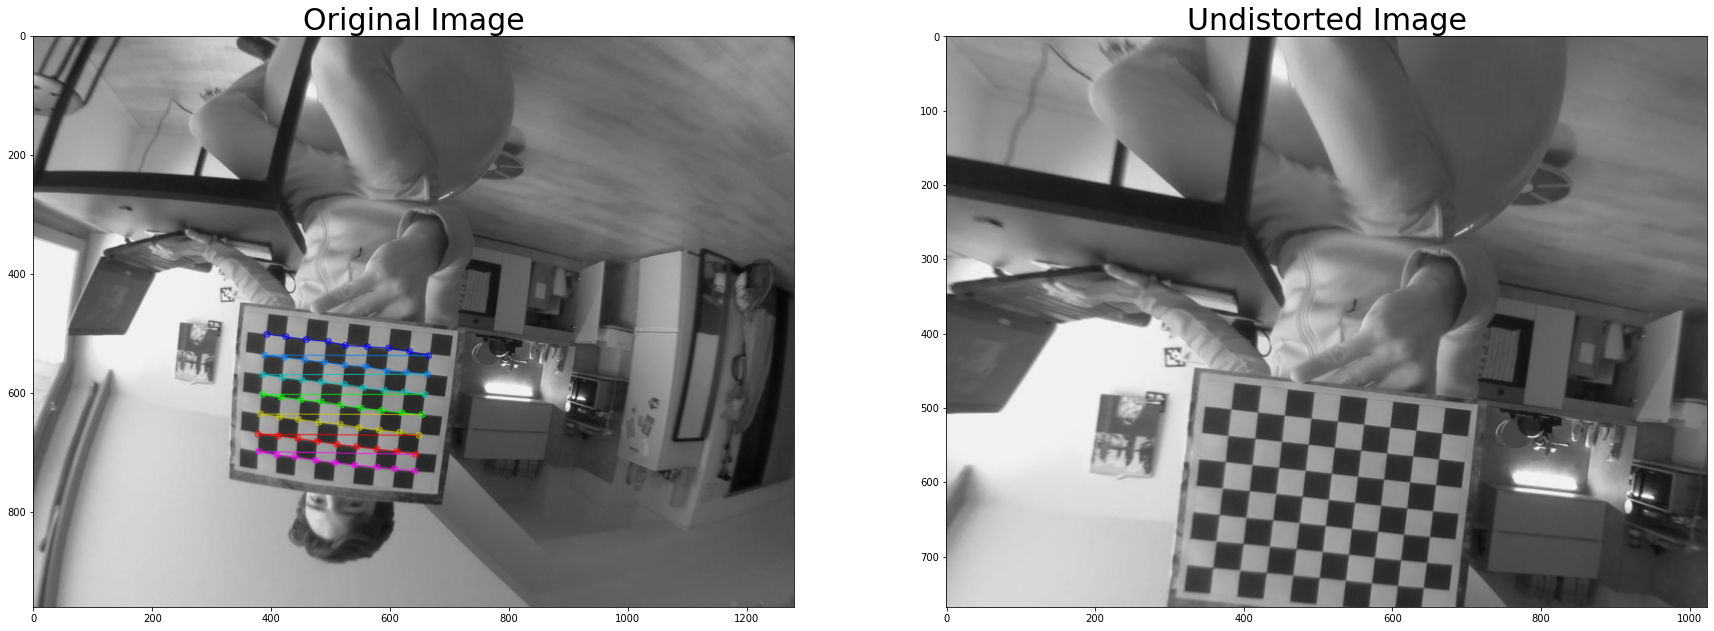

In [58]:
%matplotlib inline

# Test undistortion on an image
img = flip(cv2.imread(random.choice(images)))
img_size = (img.shape[1], img.shape[0])
print(img.shape[:2])
# Do camera calibration given object points and image points


if MODEL is FISHEYE:
    DIM=(1024, 768)
    h,w = img.shape[:2]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
else:
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)


ret, corners = cv2.findChessboardCorners(img, (board_width,board_height), None)

# If found, add object points, image points
if ret == True:
    subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
    cv2.drawChessboardCorners(img, (board_width,board_height), corners, ret)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,15))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

In [59]:
import cv2
# assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import os
import glob
CHECKERBOARD = (9,7)
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob(images_glob)
used_image_count = 0
for fname in images:
    img = flip(cv2.imread(fname))
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD)
    # print("{} - found {} corners".format(fname, len(corners) if ret == True else 0))
    # If found, add object points, image points (after refining them)
    if ret == True:
        used_image_count += 1
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
print("Found corners on {} images".format(used_image_count))


Found corners on 131 images


In [61]:

N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
# rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
# tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        # rvecs,
        # tvecs,
        flags=calibration_flags,
        # (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print(K, '\n', D)
print("Camera.fx:", K[0][0])
print("Camera.fy:", K[1][1])
print("Camera.cx:", K[0][2])
print("Camera.cy:", K[1][2])

print('\n')
print('Camera.k1:', D[0][0])
print('Camera.k2:', D[1][0])
print('Camera.k3:', D[2][0])
print('Camera.k4:', D[3][0])


Found 131 valid images for calibration
DIM=(1280, 960)
[[736.50154665   0.         622.79625164]
 [  0.         737.75236332 479.59388923]
 [  0.           0.           1.        ]] 
 [[-0.01095566]
 [-0.04700262]
 [ 0.0591146 ]
 [-0.03272505]]
Camera.fx: 736.5015466535494
Camera.fy: 737.7523633241663
Camera.cx: 622.7962516403339
Camera.cy: 479.59388922989496


Camera.k1: -0.010955659973999754
Camera.k2: -0.047002618776998864
Camera.k3: 0.059114596046676536
Camera.k4: -0.032725046003063904


In [ ]:

Camera.fx: 736.5015466535494
Camera.fy: 737.7523633241663
Camera.cx: 622.7962516403339
Camera.cy: 479.59388922989496


Camera.k1: -0.010955659973999754
Camera.k2: -0.047002618776998864
Camera.k3: 0.059114596046676536
Camera.k4: -0.032725046003063904


Camera.fx: 736.799380041753
Camera.fy: 738.1296110449435
Camera.cx: 623.0269851507727
Camera.cy: 479.41796594759063


Camera.k1: -0.011885462079235002
Camera.k2: -0.04402188574632658
Camera.k3: 0.06925286809391396
Camera.k4: -0.0457320089421333

In [16]:
print(K)
print("fx:", K[0][0])
print("fy:", K[1][1])
print("cx:", K[0][2])
print("cy:", K[1][2])

print('\n\n', D)
print('k1:', D[0][0])
print('k2:', D[1][0])
print('k3:', D[2][0])
print('k4:', D[3][0])

[[736.50154665   0.         622.79625164]
 [  0.         737.75236332 479.59388923]
 [  0.           0.           1.        ]]
fx: 736.5015466535494
fy: 737.7523633241663
cx: 622.7962516403339
cy: 479.59388922989496


 [[-0.01095566]
 [-0.04700262]
 [ 0.0591146 ]
 [-0.03272505]]
k1: -0.010955659973999754
k2: -0.047002618776998864
k3: 0.059114596046676536
k4: -0.032725046003063904
